# Timeseries - customize

In [ ]:
# By line: RRB 2020-07-29
# Script aims to:
# - Load multiple netCDF files
# - Extract one variable: CO
# - Choose a specific location from model grid
# - Plot timeseries
# - Customize visualization

### Load python packages

In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import datetime

### Create reusable functions

In [2]:
# Find nearest index
def find_index(array,x):
    idx = np.argmin(np.abs(array-x))
    return idx

### Load model Data:
Define the directories and file of interest for your results.

In [3]:
[1]: result_dir = "/home/buchholz/Documents/code_database/untracked/my-notebook/Ivan/"
   ...: files_to_open = "CAM_chem_merra2_FCSD_1deg_QFEDCMIP_Boulder_2010_2018_nh3_co_proc.nc"
   ...: #the netcdf files will be held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
   ...: nc_load1 = xr.open_dataset(result_dir+files_to_open)
   ...: #to see what the netCDF file contains, just call the variable you read it into
   ...: #nc_load1

In [ ]:
files_to_open = "CAM_chem_merra2_FCSD_1deg_QFEDCAMS_Boulder_2010_2018_nh3_co_proc.nc"
   ...: #the netcdf files will be held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
   ...: nc_load2 = xr.open_dataset(result_dir+files_to_open)
   ...: #to see what the netCDF file contains, just call the variable you read it into
   ...: #nc_load2

In [ ]:
files_to_open = "CAM_chem_merra2_FCSD_1deg_FINNCMIP_Boulder_2010_2019_nh3_co_proc.nc"
   ...: #the netcdf files will be held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
   ...: nc_load3 = xr.open_dataset(result_dir+files_to_open)
   ...: #to see what the netCDF file contains, just call the variable you read it into
   ...: #nc_load3

### Extract the variable at the time and level and location of choice

In [4]:
#extract variable
#WD_NH3
select_species = 'CO'
var_cmip = nc_load1[select_species]
var_cams = nc_load2[select_species]
var_finn = nc_load3[select_species]

units = var_cams.units

 #extract grid variables
 lat = nc_load1['lat']
 lon = nc_load1['lon']
   ...: time_cmip = nc_load1['time']
   ...: time_cams = nc_load2['time']
   ...: time_finn = nc_load3['time']
   ...:
   ...: # CAM-chem writes the month average at midnight - i.e. the start of the next month.
   ...: # Reconfigure the time variable
   ...: time2_cmip = pd.to_datetime(time_cmip.values,format='%Y-%m-%dT%H:%M:%S')+DateOffset(months=-1,days=+14)
   ...: time2_cams = pd.to_datetime(time_cams.values,format='%Y-%m-%dT%H:%M:%S')+DateOffset(months=-1,days=+14)
   ...: time2_finn = pd.to_datetime(time_finn.values,format='%Y-%m-%dT%H:%M:%S')+DateOffset(months=-1,days=+14)
   ...:
   ...:
   ...: #var_cams['time'] = time2_cams
   ...: #var_cmip['time'] = time2_cmip
   ...: #var_finn['time'] = time2_finn
   ...:
   ...: print("file time: ", time_cmip[0].values, "---> converted time: ", time2_cmip[0])

file time:  2018-02-01T00:00:00.000000000 ---> converted time:  2018-01-15 00:00:00


### Select and extract the location.

In [5]:
In [1]: name_select = "Boulder"
   ...: lat_select = 40.0150n [1]: result_dir = "/home/buchholz/Documents/code_database/untracked/my-notebook/Ivan/"
   ...: files_to_open = "CAM_chem_merra2_FCSD_1deg_QFEDCMIP_Boulder_2010_2018_nh3_co_proc.nc"
   ...: #the netcdf files will be held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
   ...: nc_load1 = xr.open_dataset(result_dir+files_to_open)
   ...: #to see what the netCDF file contains, just call the variable you read it into
   ...: #nc_load1
   ...: lon_select = 360-105.2705 # model longitude is from 0 to 360
   ...:
   ...: lat_i = find_index(lat,lat_select)
   ...: lon_i = find_index(lon,lon_select)
   ...:
   ...: print(name_select, " latitude: ", lat_select, "---> nearest: ", lat[lat_i].values)
   ...: print(name_select, " longitude: ", lon_select, "---> nearest: ", lon[lon_i].values)
   ...:
   ...: # extract location surface value and convert to ppb
   ...: var_cmip_srf = var_cmip.isel(lat=lat_i,lon=lon_i)
   ...: var_cams_srf = var_cams.isel(lat=lat_i,lon=lon_i)
   ...: var_finn_srf = var_finn.isel(lat=lat_i,lon=lon_i)
   ...: print(var_finn_srf)

Boulder  latitude:  40.015 ---> nearest:  40.0523560209424
Boulder  longitude:  254.7295 ---> nearest:  255.0


In [ ]:
#-------------------------------
   ...: #CONSTANTS and conversion factor
   ...: #-------------------------------
   ...: NAv = 6.0221415e+23                       #--- Avogadro's number
   ...: g = 9.81                                  #--- m/s - gravity
   ...: MWair = 28.94                             #--- g/mol
   ...: xp_const = (NAv* 10)/(MWair*g)      #--- scaling factor for turning vmr into pcol
   ...:                                           #--- (note 1*e-09 because in ppb)

In [ ]:
# Load values to create true model pressure array
   ...: psurf1 = nc_load1['PS'].isel(lat=lat_i,lon=lon_i)
   ...: psurf2 = nc_load2['PS'].isel(lat=lat_i,lon=lon_i)
   ...: psurf3 = nc_load3['PS'].isel(lat=lat_i,lon=lon_i)
   ...:
   ...: hyai = nc_load1['hyai']
   ...: hybi = nc_load1['hybi']
   ...: p0 = nc_load1['P0']
   ...: lev = var_finn_srf.coords['lev']
   ...: num_lev = lev.shape[0]
   ...:
   ...: # Initialize pressure edge arrays
   ...: mod_press_low1 = xr.zeros_like(var_cmip_srf)
   ...: mod_press_top1 = xr.zeros_like(var_cmip_srf)
   ...: mod_press_low2 = xr.zeros_like(var_cams_srf)
   ...: mod_press_top2 = xr.zeros_like(var_cams_srf)
   ...: mod_press_low3 = xr.zeros_like(var_finn_srf)
   ...: mod_press_top3 = xr.zeros_like(var_finn_srf)
   ...:
   ...: # Calculate pressure edge arrays
   ...: # CAM-chem layer indices start at the top and end at the bottom
   ...: for i in range(num_lev):
   ...:     mod_press_top1[:,i] = hyai[i]*p0 + hybi[i]*psurf1
   ...:     mod_press_low1[:,i] = hyai[i+1]*p0 + hybi[i+1]*psurf1
   ...:     mod_press_top2[:,i] = hyai[i]*p0 + hybi[i]*psurf2
   ...:     mod_press_low2[:,i] = hyai[i+1]*p0 + hybi[i+1]*psurf2
   ...:     mod_press_top3[:,i] = hyai[i]*p0 + hybi[i]*psurf3
   ...:     mod_press_low3[:,i] = hyai[i+1]*p0 + hybi[i+1]*psurf3
   ...:
   ...: # Delta P in hPa
   ...: mod_deltap1 = (mod_press_low1 - mod_press_top1)/100
   ...: mod_deltap2 = (mod_press_low2 - mod_press_top2)/100
   ...: mod_deltap3 = (mod_press_low3 - mod_press_top3)/100

In [ ]:
var_cmip_tcol = xr.dot(mod_deltap1, xp_const*var_cmip_srf, dims=["lev"])
   ...: var_cams_tcol = xr.dot(mod_deltap2, xp_const*var_cams_srf, dims=["lev"])
   ...: var_finn_tcol = xr.dot(mod_deltap3, xp_const*var_finn_srf, dims=["lev"])
   ...:
   ...: var_cams_tcol['time'] = time2_cams
   ...: var_cmip_tcol ['time'] = time2_cmip
   ...: var_finn_tcol['time'] = time2_finn

### Plot the value versus time.

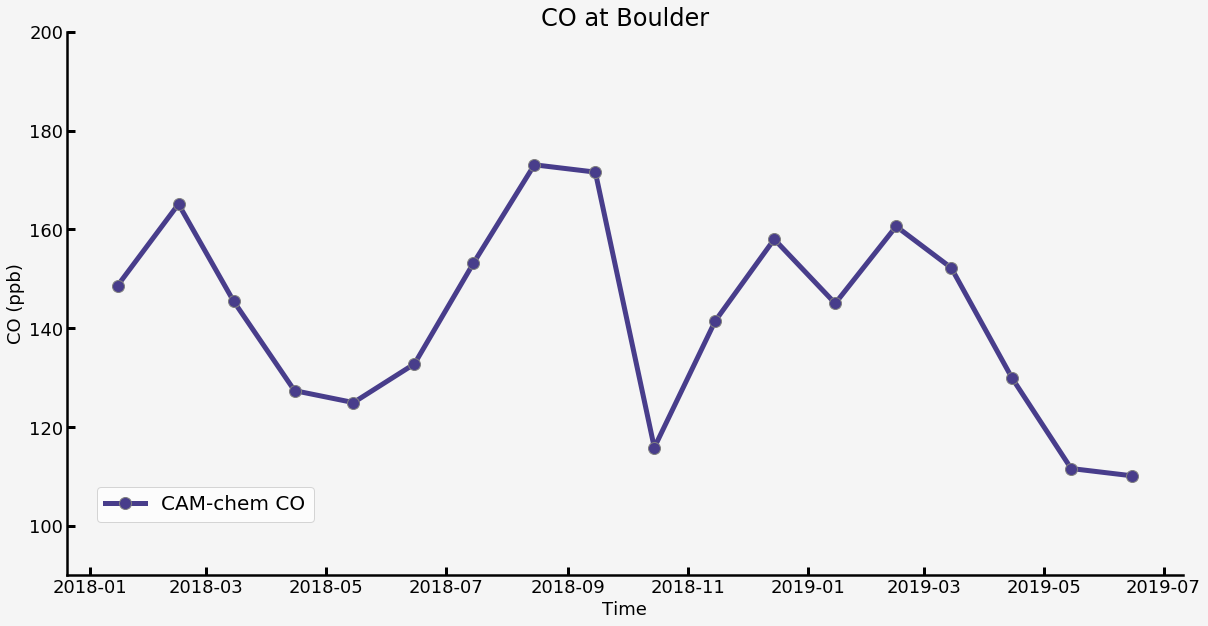

In [122]:
plt.figure(figsize=(20,10),facecolor='whitesmoke')
   ...: ax = plt.axes(facecolor='whitesmoke')
   ...:
   ...: plt.plot(time2_cmip, var_cmip_tcol, '-o', label='CAM-chem '+select_species+': QFED/CMIP',
   ...:          color='darkslateblue',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkslateblue',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.plot(time2_cams, var_cams_tcol, '-o', label='CAM-chem '+select_species+': QFED/CAMS',
   ...:          color='red',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='red',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.plot(time2_finn, var_finn_tcol, '-o', label='CAM-chem '+select_species+': FINN/CMIP',
   ...:          color='darkgreen',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkgreen',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: #resources: named colors - https://matplotlib.org/examples/color/named_colors.html
   ...: #           default markers and lines list - https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
   ...:
   ...: # axes format
   ...: plt.xticks(fontsize=18)
   ...: #ax.set_ylim(90, 200)
   ...: #plt.yticks(np.arange(100, 220, step=20), fontsize=18)
   ...:
   ...: # tickmarks direction
   ...: ax.tick_params(direction='in', length=8, width=3)
   ...:
   ...: # adjust border
   ...: ax.spines["left"].set_linewidth(2.5)
   ...: ax.spines["bottom"].set_linewidth(2.5)
   ...: ax.spines["right"].set_visible(False)
   ...: ax.spines["top"].set_visible(False)

# titles
   ...: plt.title('Monthly '+select_species + ' ('+var_cmip_srf.long_name+') at ' + name_select,fontsize=24)
   ...: plt.xlabel('Time',fontsize=18)
   ...: #plt.ylabel(select_species+' '+units,fontsize=18)
   ...: plt.ylabel(select_species+' column',fontsize=18)
   ...:
   ...:
   ...: # legend
   ...: plt.legend(bbox_to_anchor=(0.93, 0.88),loc='lower right')
   ...:
   ...: # write to show the whole plot
   ...: plt.show()

In [ ]:
month_length = var_cams_srf.time.dt.days_in_month
   ...: #cams_yearly = var_cams_srf.groupby('time.year').mean('time')
   ...: #cmip_yearly = var_cmip_srf.groupby('time.year').mean('time')
   ...: #finn_yearly = var_finn_srf.groupby('time.year').mean('time')
   ...: cams_yearly = var_cams_tcol.groupby('time.year').mean('time')
   ...: cmip_yearly = var_cmip_tcol.groupby('time.year').mean('time')
   ...: finn_yearly = var_finn_tcol.groupby('time.year').mean('time')

In [ ]:
plt.figure(figsize=(20,10),facecolor='whitesmoke')
   ...: ax = plt.axes(facecolor='whitesmoke')
   ...:
   ...: plt.plot(cmip_yearly.year.values[1:], cmip_yearly[1:], '-o', label='CAM-chem '+select_species+': QFED/CMIP',
   ...:          color='darkslateblue',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkslateblue',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.plot(cams_yearly.year.values, cams_yearly, '-o', label='CAM-chem '+select_species+': QFED/CAMS',
   ...:          color='red',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='red',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.plot(finn_yearly.year.values[1:], finn_yearly[1:], '-o', label='CAM-chem '+select_species+': FINN/CMIP',
   ...:          color='darkgreen',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkgreen',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...:
   ...: #resources: named colors - https://matplotlib.org/examples/color/named_colors.html
   ...: #           default markers and lines list - https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
   ...:
   ...: # axes format
   ...: plt.xticks(fontsize=18)
   ...: #ax.set_ylim(90, 200)
   ...: #plt.yticks(np.arange(100, 220, step=20), fontsize=18)
   ...:
   ...: # tickmarks direction
   ...: ax.tick_params(direction='in', length=8, width=3)
   ...:
   ...: # adjust border
   ...: ax.spines["left"].set_linewidth(2.5)
   ...: ax.spines["bottom"].set_linewidth(2.5)
   ...: ax.spines["right"].set_visible(False)
   ...: ax.spines["top"].set_visible(False)
    
    # titles
   ...: plt.title('Yearly '+select_species + ' ('+var_cmip_srf.long_name+') at ' + name_select,fontsize=24)
   ...: plt.xlabel('Time',fontsize=18)
   ...: #plt.ylabel(select_species+' '+units,fontsize=18)
   ...: plt.ylabel(select_species+' column',fontsize=18)
   ...:
   ...:
   ...: # legend
   ...: plt.legend(bbox_to_anchor=(0.23, 0.08),loc='lower right')
   ...:
   ...: # write to show the whole plot
   ...: plt.show()
    

In [ ]:
#cams_clim = var_cams_srf.groupby('time.month').mean('time')
   ...: #cmip_clim = var_cmip_srf.groupby('time.month').mean('time')
   ...: #finn_clim = var_finn_srf.groupby('time.month').mean('time')
   ...:
   ...: #cmip_clim_sd = var_cmip_srf.groupby('time.month').std('time')
   ...: #cams_clim_sd = var_cams_srf.groupby('time.month').std('time')
   ...: #finn_clim_sd = var_finn_srf.groupby('time.month').std('time')
   ...:
   ...: cams_clim = var_cams_tcol.groupby('time.month').mean('time')
   ...: cmip_clim = var_cmip_tcol.groupby('time.month').mean('time')
   ...: finn_clim = var_finn_tcol.groupby('time.month').mean('time')
   ...:
   ...: cmip_clim_sd = var_cmip_tcol.groupby('time.month').std('time')
   ...: cams_clim_sd = var_cams_tcol.groupby('time.month').std('time')
   ...: finn_clim_sd = var_finn_tcol.groupby('time.month').std('time')

In [ ]:
plt.figure(figsize=(20,10),facecolor='whitesmoke')
   ...: ax = plt.axes(facecolor='whitesmoke')
   ...:
   ...: plt.plot(cmip_clim.month.values, cmip_clim,
   ...:          '-o', label='CAM-chem '+select_species+': QFED/CMIP',
   ...:          color='darkslateblue',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkslateblue',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.errorbar(cmip_clim.month.values, cmip_clim, cmip_clim_sd,color='darkslateblue')
   ...:
   ...: plt.plot(cams_clim.month.values, cams_clim, '-o', label='CAM-chem '+select_species+': QFED/CAMS',
   ...:          color='red',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='red',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.errorbar(cams_clim.month.values, cams_clim, cams_clim_sd,color='red')
   ...:
   ...: plt.plot(finn_clim.month.values, finn_clim, '-o', label='CAM-chem '+select_species+': FINN/CMIP',
   ...:          color='darkgreen',
   ...:          markersize=12, linewidth=5,
   ...:          markerfacecolor='darkgreen',
   ...:          markeredgecolor='grey',
   ...:          markeredgewidth=1)
   ...:
   ...: plt.errorbar(finn_clim.month.values, finn_clim, finn_clim_sd,color='darkgreen')
   ...:
   ...:
   ...: #resources: named colors - https://matplotlib.org/examples/color/named_colors.html
   ...: #           default markers and lines list - https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
   ...:
   ...: # axes format
   ...: plt.xticks(fontsize=18)
   ...: #ax.set_ylim(90, 200)
   ...: #plt.yticks(np.arange(100, 220, step=20), fontsize=18)
   ...:
   ...: # tickmarks direction
    ax.tick_params(direction='in', length=8, width=3)
   ...:
   ...: # adjust border
   ...: ax.spines["left"].set_linewidth(2.5)
   ...: ax.spines["bottom"].set_linewidth(2.5)
   ...: ax.spines["right"].set_visible(False)
   ...: ax.spines["top"].set_visible(False)
   ...:
   ...: # titles
   ...: plt.title('Climatological month average '+select_species + ' ('+var_cmip_srf.long_name+') at ' + name_select,fontsize=2
   ...: 4)
   ...: plt.xlabel('Time',fontsize=18)
   ...: #plt.ylabel(select_species+' '+units,fontsize=18)
   ...: plt.ylabel(select_species+' column',fontsize=18)
   ...:
   ...:
   ...: # legend
   ...: plt.legend(bbox_to_anchor=(0.93, 0.88),loc='lower right')
   ...:
   ...: # write to show the whole plot
   ...: plt.show()